In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import re
import itertools

In [6]:

path = "../data/results/"
palette = sns.color_palette("deep")

In [7]:
def preprocess_line(line):
       # Remove the 'device' entry
        line = re.sub(r"'device': device\(.*?\),?", "", line)
        line = re.sub(r"array\((\[.*?\])\)", r"\1", line)
        return line

def get_data(path, scenario, dataset, model, logs="/logs.txt"):
        filepath = path + scenario + "/" + dataset + "/" + model
        with open(filepath + logs, "r") as file:
                dictlist = list()
                for line in file:
                        line = preprocess_line(line)
                        dictlist.append(ast.literal_eval(line))
                return dictlist, filepath

def get_arguments(dictionary):
        base = ["dataset", "model"]
        keep = ["dataset", "model"]
        combine = []
        if "seed" in dictionary:
                base.append("seed")
                keep.append("seed")
        if "permute_classes" in dictionary:
                base.append("permute_classes")
                keep.append("permute_classes")
        if "buffer_size" in dictionary:
                base.append("buffer_size")
                keep.append("buffer_size")
        if "lr" in dictionary:
                base.append("lr")
                combine.append("lr")
        if "alpha" in dictionary:
                base.append("alpha")
                combine.append("alpha")
        if "beta" in dictionary:
                base.append("beta")
                combine.appen("beta")
        if "temperature" in dictionary:
                base.append("temperature")
                combine.append("temperature")
        if "result_type" in dictionary:
                base.append("result_type")
                keep.append("result_type")
        if "portion" in dictionary:
                base.append("portion")
                keep.append("portion")
        
        return base, keep, combine


def get_dataframe(dictlist, keep_arguments):
        df = pd.DataFrame(dictlist)
        df = df.drop(columns=[col for col in df.columns if col not in (keep_arguments)])

        #if the temperature is above 100, we used the mse approximation
        if "temperature" in keep_arguments:
                index = df['temperature'] > 100
                df["temperature"] = df["temperature"].astype("str")
                df.loc[index, 'temperature'] = 'mse'
        return df

def get_arrays(dictionary, pre_string1='accuracy', pre_string2='accmean_task'):
        dataset = dictionary['dataset']
        accmean_columns = list()
        acctask_columns = list()

        amount_task = 0
        if(any(substring in dataset for substring in ["seq-tinyimg"])):
                amount_task = 10
        elif(any(substring in dataset for substring in ["rot-mnist", "perm-mnist"])):
                amount_task = 20
        elif(any(substring in dataset for substring in ["seq-mnist", "seq-cifar10"])):
                amount_task = 5
        for i in range(1, amount_task+1):
                accmean_columns.append(pre_string2 + f"{i}")
                for j in range(1, i+1):
                        acctask_columns.append(pre_string1 + f"_{j}_task{i}")
        result_accuracy = accmean_columns[-1]

        return accmean_columns, acctask_columns, result_accuracy

def plotting_name(logging_name):
        if logging_name == 'er_bounds':
                return 'ER'
        elif logging_name == 'sgd':
                return 'JOINT'
        elif logging_name == 'fdr':
                return 'FDR'
        elif logging_name == 'der':
                return 'DER'
        elif logging_name == 'icarl':
                return 'iCaRL'
        elif logging_name == 'supcon':
                return 'Co2L'
        elif logging_name == 'seq-cifar10':
                return 'Seq-Cifar10'
        elif logging_name == 'seq-tinyimg':
                return 'Seq-TinyIMG'
        elif logging_name == 'class-il':
                return 'CIL'
        elif logging_name == 'task-il':
                return 'TIL'
        else:
                return logging_name

def replace(dataframe, key, new_value):
        dataframe[key] = new_value

def group_df(df, filter, keep_arguments, group_arguments, result_accuracy):
        #First filter
        grouped = df
        if filter is not None:
                for key, value in filter.items():
                        grouped = grouped[grouped[key] == value]
        #Group according to all arguments
        grouped = grouped.groupby(keep_arguments + group_arguments, as_index=False).agg({result_accuracy: 'mean'})
        #print(grouped)
        #Calculate max of mean for arguments we should keep for plotting
        best = grouped.groupby(keep_arguments, as_index=False).agg({result_accuracy: 'max'})
        best = grouped.merge(best[result_accuracy], on=[result_accuracy], how='inner')
        #print(best)
        #Filter dataframe according to best arguments
        best = best.drop(result_accuracy, axis=1)
        result = df.merge(best, on=(keep_arguments + group_arguments), how='inner')
        #print(result)
        return result

## Output - Features 

TypeError: 'Axes' object is not iterable

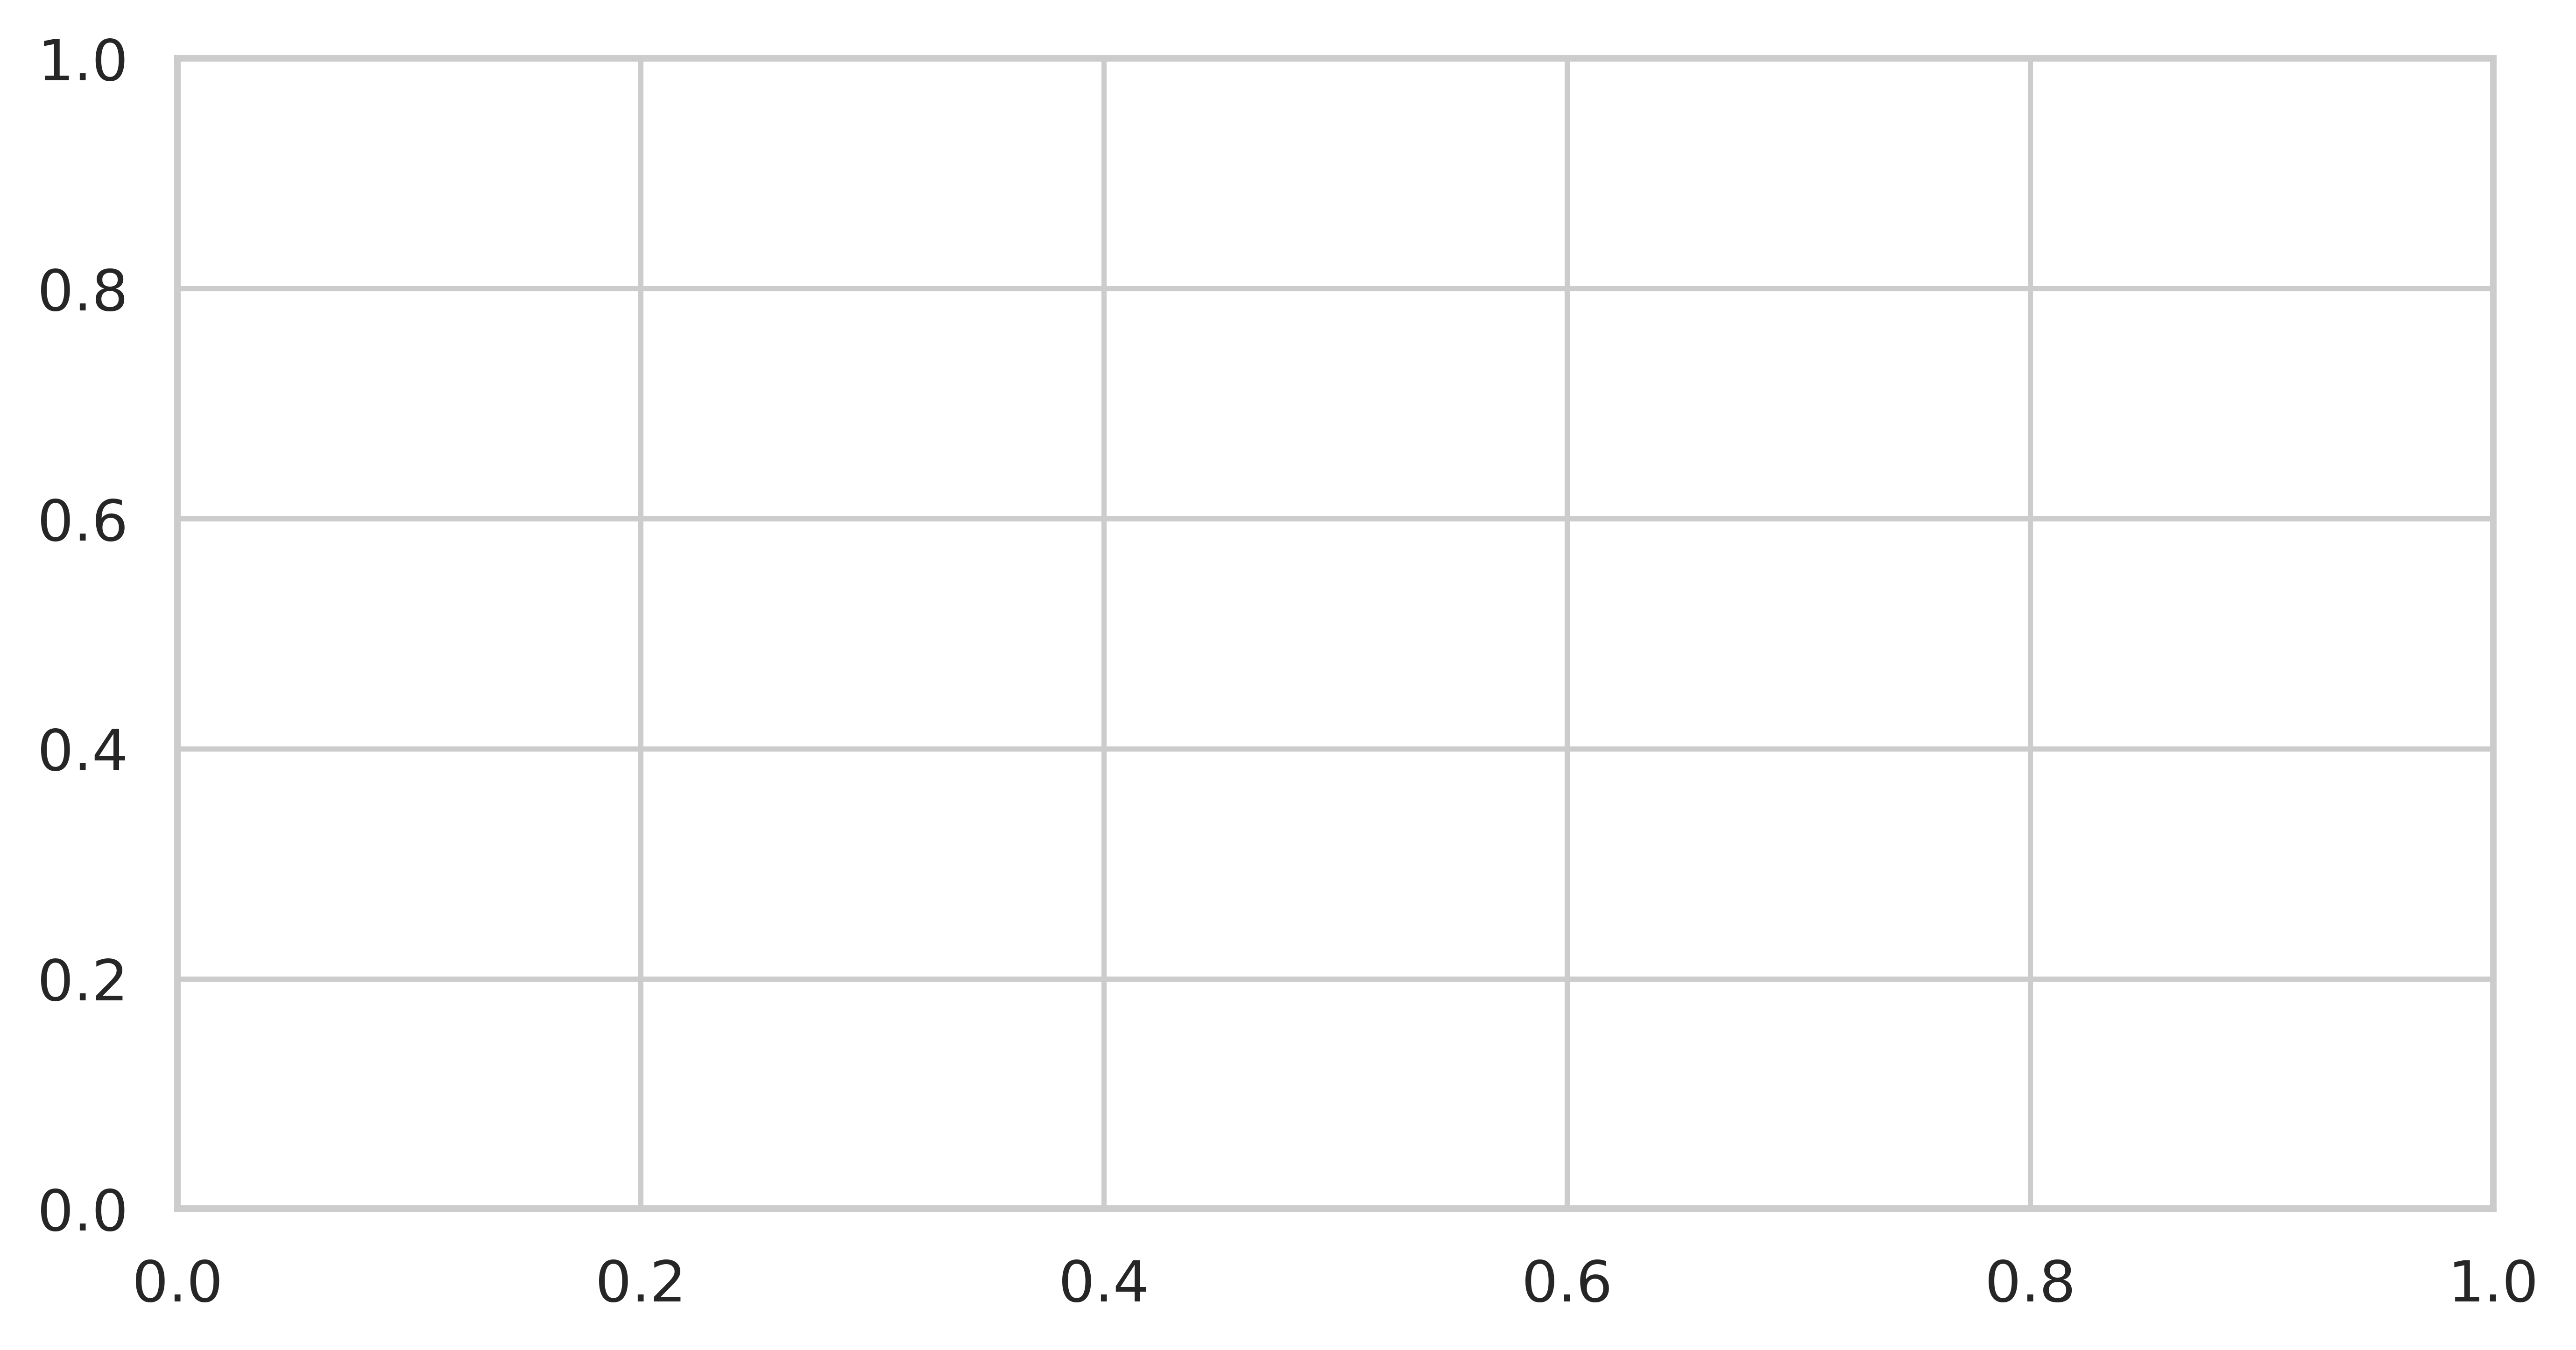

In [ ]:
sns.set_theme(style="whitegrid")
color_mapping = {"ER offline": '#F28E2B', "DER online": '#4E79A7', "DER offline": '#59A14F', "JOINT": '#000000', 'supcon': 'black'}
line_mapping = {'output': (1, 0), 'features': (5, 2), 'buffer': (2, 2)}
datasets = ['seq-cifar10']
training_setting = ['task-il', 'class-il']
models = ['supcon']
fig, axes = plt.subplots(1, len(datasets)*len(training_setting), figsize=(8, 4), dpi=800)

for i, (ax, setting) in enumerate(zip(axes, list(itertools.product(datasets, training_setting)))):
        data_buffer = []
        data_nobuffer = []
        for model in models:
                dictlist, filepath = get_data(path, setting[1], setting[0], model)
                arguments_base, arguments_keep, arguments_combine = get_arguments(dictlist[0])
                accmean_columns, acctask_columns, result_accuracy = get_arrays(dictlist[0])

                df = get_dataframe(dictlist, arguments_base + [result_accuracy])
                if model in ['supcon']: 
                        df = df[df['seed'].isin([1000,2000,3000])]
                        df = df[df['permute_classes'] == 1]
                if model in ['er_bounds', 'supcon']:
                        df = df[df['result_type'].isin(list(['output', 'features', 'buffer']))]
                else:
                        df = df[df['result_type'].isin(list(['output']))]

                #result = group_df(df, None, arguments_keep, arguments_combine, result_accuracy)
                print(df)

                replace(df, 'model', plotting_name(model))
                if 'buffer_size' in arguments_base:
                        buffer_sizes = sorted(df['buffer_size'].unique())
                        if model == 'er_bounds':
                                df['buffer_size'] = df['buffer_size'].replace(100000, 2*buffer_sizes[-2] - buffer_sizes[-3])
                        else:
                                df = df[df['buffer_size'] != 100000]

                        data_buffer.append(df)
                else:
                        data_nobuffer.append(df)   
        
        data_buffer = pd.concat(data_buffer)
        #data_nobuffer = pd.concat(data_nobuffer)

        all_buffer_sizes = data_buffer['buffer_size'].unique()
        df_buffer_sizes = pd.DataFrame({'buffer_size': all_buffer_sizes})
        #data_nobuffer = data_nobuffer.merge(df_buffer_sizes, how='cross')

        sns.lineplot(data=data_buffer, x='buffer_size', y=result_accuracy, hue='model', style='result_type',  markers=True, dashes=line_mapping, legend=(i==0), ax=ax, palette="YlOrBr_r")
        #sns.lineplot(data=data_nobuffer, x='buffer_size', y=result_accuracy, hue='model', marker='',  linestyle='-', legend=(i==0), palette=color_mapping, ax=ax)
        if i==0:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend_.remove()

        ax.set_title(plotting_name(setting[0]) + ' (' + plotting_name(setting[1]) + ')')
        ax.set_xlabel("Buffer Size")
        if i==0:
                ax.set_ylabel("Test Accuracy")
        else:
                ax.set_ylabel("")

fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.8, 0.5), ncol=1)
fig.tight_layout(rect=[0, 0.05, 1, 1])
#fig.savefig(path + f"/Output_vs_Features.png")
#fig.clf() 

## NC plot

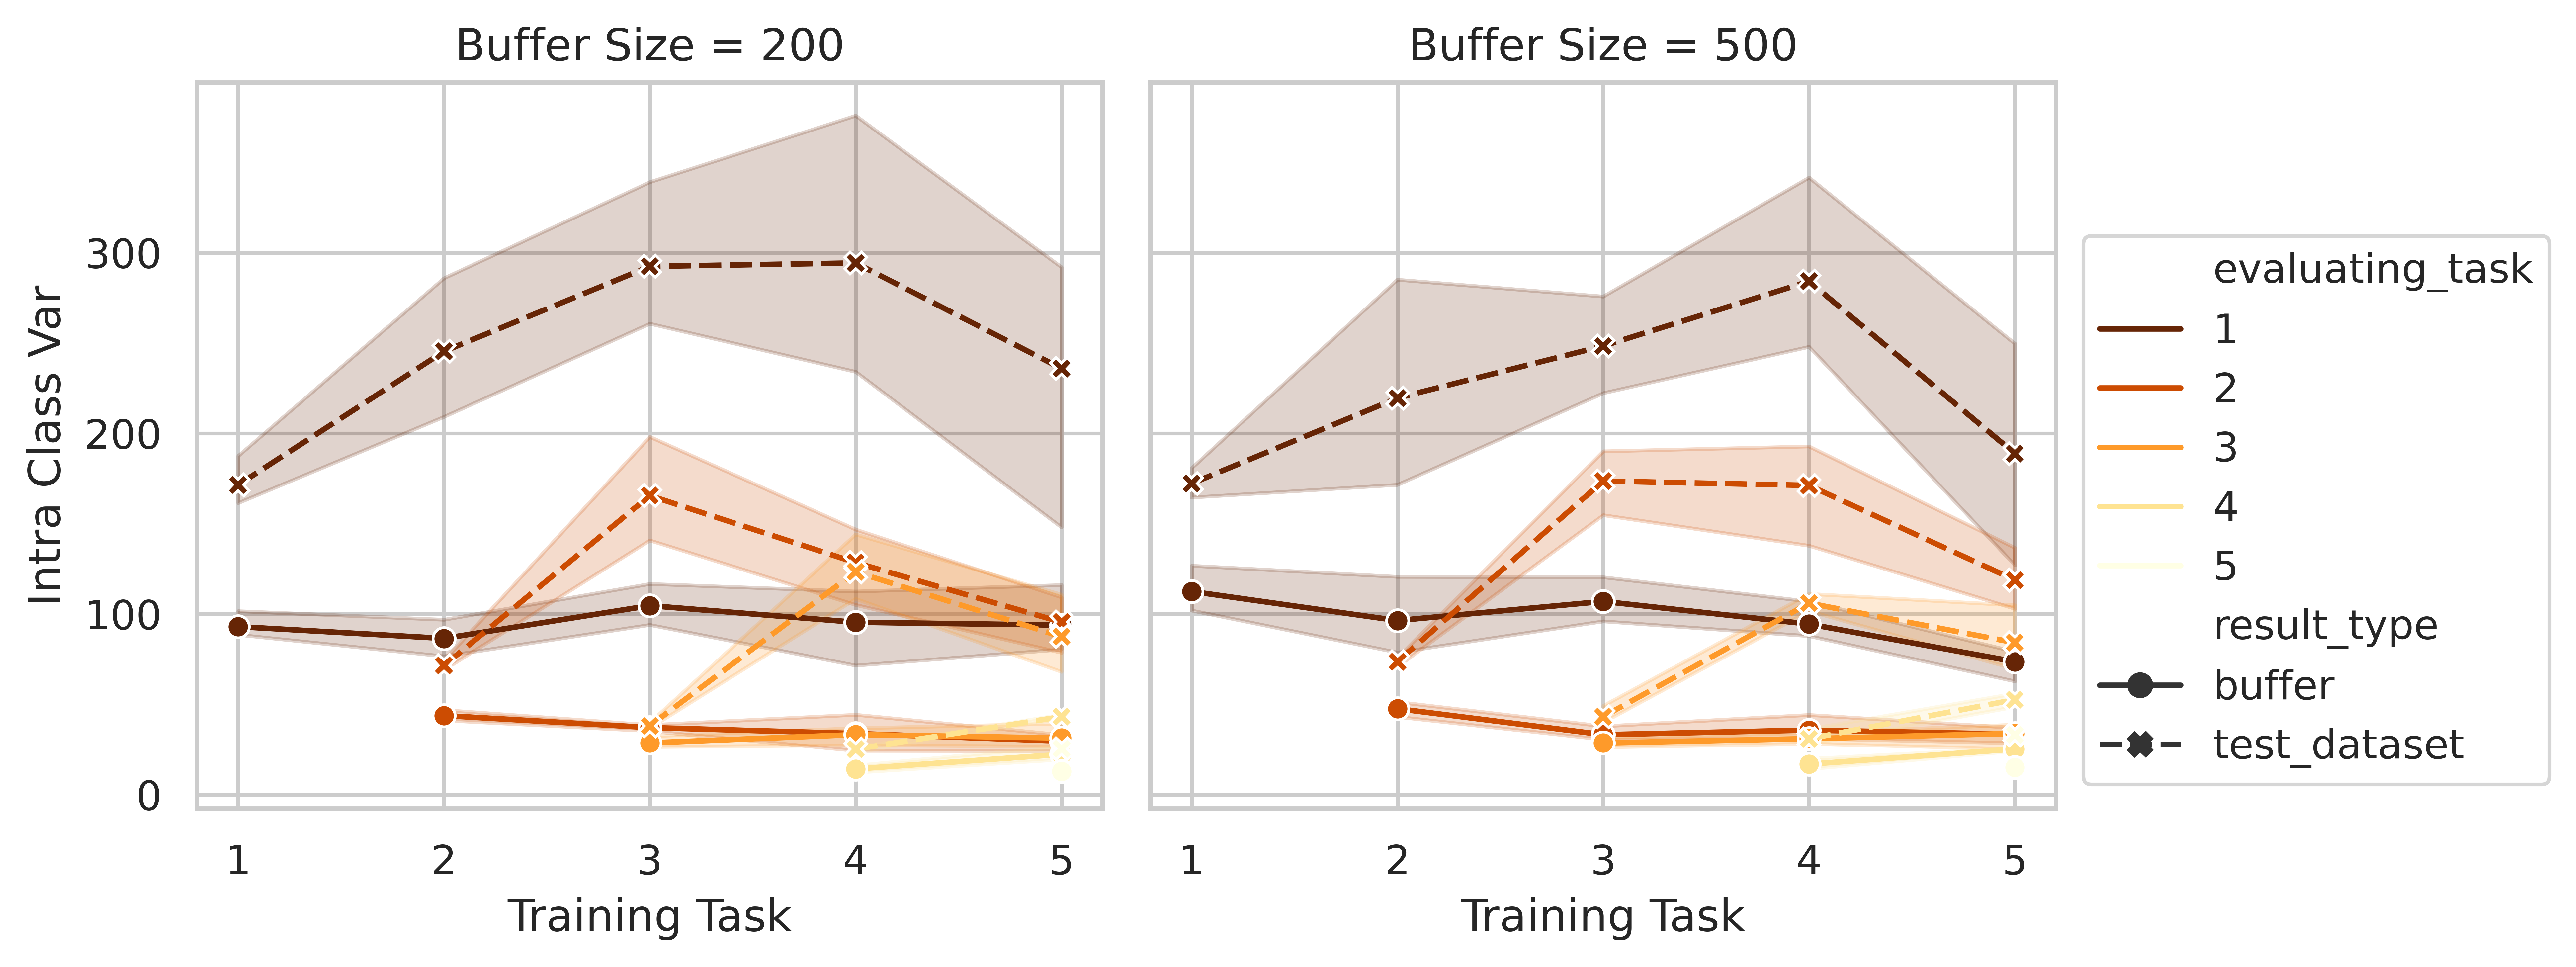

In [36]:
sns.set_theme(style="whitegrid")
color_mapping = {"ER offline": '#F28E2B', "DER online": '#4E79A7', "DER offline": '#59A14F', 'supcon': '#FF9DA6'}
datasets = {'seq-cifar10': [200, 500]}
model = 'supcon'
training_setting = 'class-il'
result_type = {'solid_line': 'buffer','dashed_line': 'test_dataset', 'dotted_line': 'extra_buffer'}
version = 'intra_class_var'
fig, axes = plt.subplots(len(datasets), 2, figsize=(8, 4), dpi=800, sharey=True)

for row, (c_dataset, buffer_sizes) in enumerate(datasets.items()):
        dictlist, filepath = get_data(path, training_setting, c_dataset, model, "/logs_NC.txt")
        arguments_base, arguments_keep, arguments_combine = get_arguments(dictlist[0])
        accmean_columns, acctask_columns, result_accuracy = get_arrays(dictlist[0], version, 'inter_class_var')
        df = get_dataframe(dictlist, arguments_base + accmean_columns + acctask_columns + [result_accuracy])
        replace(df, "model", plotting_name(model))
        df = df[df['result_type'].isin(list(result_type.values()))]

        #df = group_df(df, None, arguments_keep, arguments_combine, result_accuracy)
        for col, buffer_size in enumerate(buffer_sizes):
                ax = axes[row + col] #attention
                current_df = df[df['buffer_size'] == buffer_size]

                results = []
                for i, _ in enumerate(accmean_columns, start=1):
                        for j in range(1, i+1):
                                if(j%2==1 and c_dataset=='seq-tinyimg'):
                                        continue
                                current_result = pd.DataFrame({'training_task': i, 'evaluating_task': j, 
                                                                'accuracy': (current_df[version +f"_{j}_task{i}"]  /  1.0), 'result_type': current_df['result_type']})
                                results.append(current_result) 

                results = pd.concat(results)
                sns.lineplot(data=results, x='training_task', y='accuracy', hue='evaluating_task', style='result_type', markers=True, dashes=True, legend=(col+row==0), ax=ax, palette="YlOrBr_r")
                if row+col==0:
                        handles, labels = ax.get_legend_handles_labels()
                        ax.legend_.remove()
                
                ax.set_title(f'Buffer Size = {buffer_size}')
                ax.set_xlabel("Training Task")
                if col==0:
                        ax.set_ylabel("Intra Class Var")
                else:
                        ax.set_ylabel("")
                
fig.legend(handles, labels, loc='center', bbox_to_anchor=(1.1, 0.5), ncol=1)
fig.tight_layout(rect=[0, 0.05, 1, 1])
#fig.savefig(path + f"/NC.png")
#fig.clf() 